In [50]:
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
from hurst import compute_Hc
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import yfinance as yf
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

In [51]:
access_token = "9c7349b9a9bd3d17409758cb7e29e53f-7fcbdfe7bc0636788aa51f7e4a95601f"
account_id = "101-003-28600525-001"

accountID = account_id
access_token = access_token

api = API(access_token=access_token)

In [52]:
class Momentum_Hurst_RSI():

    def __init__(self, instrument, params, short_term_window, long_term_window, hurst_window ): # params: from, to, granularity
        self.instrument = instrument
        self.params = params
        self.ST_window = short_term_window
        self.LT_window = long_term_window
        # Hurst exponent
        self.hurst_window = hurst_window

        # RSI indicator, same as the short term window
        self.RSI_window = short_term_window
        self.prepare_data()
    

    def prepare_data(self):
        # Make a request
        r = instruments.InstrumentsCandles(instrument=self.instrument, params=self.params)
        data = api.request(r)

        # Extract date and closing price and form as a DataFrame
        dates = [candle['time'][:10] for candle in data['candles']]  # Intercept the first 10 characters to get the date
        close_prices = [float(candle['mid']['c']) for candle in data['candles']]  # Get Close Price

        # Create DataFrame, row_index: date; column: close price
        bt_data = pd.DataFrame(data=close_prices, index=pd.to_datetime(dates), columns=['Close_Price'])


        # Calculate the momentum and the Hurst exponent
        bt_data['ShortTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.ST_window)
        bt_data['LongTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.LT_window)    
        bt_data['Hurst'] = bt_data['Close_Price'].rolling(window=self.hurst_window).apply(lambda x: compute_Hc(x)[0])

        # Calculating the RSI
        rsi_indicator = RSIIndicator(close = bt_data['Close_Price'], window = self.RSI_window, fillna = False)
        RSI = rsi_indicator.rsi()

        # Adding the RSI to the dataframe
        bt_data['RSI'] = RSI

        bt_data = bt_data.dropna()
        self.data = bt_data
        
    def strategy(self):
        
        data = self.data
         
        # data['Position'] = 1
        data.loc[(data['Hurst'] > 0.5) & (data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] > 0), 'Position'] = 1 # Hurst exponent greater than 0.5, short term and long term momentum greater than 0, buy
        data.loc[(data['Hurst'] > 0.5) & (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] < 0), 'Position'] = -1

        # Out of the market
        data.loc[(data['RSI'] <= 70) & (data['Hurst'] > 0.5) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = 1
        data.loc[(data['RSI'] > 70) & (data['Hurst'] > 0.5) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = -1
        data.loc[(data['Hurst'] < 0.5) & (data['RSI'] <= 70), 'Position'] = 1
        data.loc[(data['Hurst'] < 0.5) & (data['RSI'] > 70), 'Position'] = -1

        data['Signal'] = data['Position'].diff()
        data = data.dropna()

        data['Instrument_Returns'] = np.log(data['Close_Price']/data['Close_Price'].shift(1))
        data['Strategy_Returns'] = data['Instrument_Returns'] * data['Position'].shift(1)

        self.visualise_data = data
    
    def visualise_strategy(self):
        print('-------------------')
        print('Visualising the Strategy crossover period')
        bt_data = self.visualise_data
        plt.figure(figsize=(15, 5))
        plt.plot(bt_data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
        plt.plot(bt_data["ShortTermMomentum"], color='b', label='Short term Momentum')
        plt.plot(bt_data["LongTermMomentum"], color='r', label='Long term Momentum')
        plt.plot(bt_data["Hurst"], color='g', label='Hurst Exponent')

        # plot ‘buy crossover’ signals.
        # Because I have used +1 and -1,
        # A buy signal will be created when the position was -1 and it turned to +1
        # difference of +1 - -1 will give me 2

        plt.plot(bt_data[bt_data['Signal'] == 2].index,
                bt_data['Close_Price'][bt_data['Signal'] == 2],
                '^', markersize = 15, color = 'g', label = 'buy/long')

        # plot ‘sell crossover ’ signals
        plt.plot(bt_data[bt_data['Signal'] == -2].index,
                bt_data['Close_Price'][bt_data['Signal'] == -2],
                'v', markersize = 15, color = 'r', label = 'sell/short')

        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Moving Averages Crossover {} Vs {}".format(self.ST_window, self.LT_window))
        plt.legend()
        plt.grid()
        plt.show()

    def performance(self):

        print('-------------------')
        print('Performance of the Strategy')
        print('-------------------')

        bt_data = self.visualise_data

        daily_ret = bt_data[['Instrument_Returns', 'Strategy_Returns']].mean()
        annual_ret = daily_ret * 252
        annual_regular_ret = np.exp(annual_ret) - 1

        print('Annual Regular Return:', annual_regular_ret)

        daily_std = bt_data[['Instrument_Returns', 'Strategy_Returns']].std()
        annual_std = daily_std * math.sqrt(252)
        daily_regular_std = (np.exp(bt_data[['Instrument_Returns', 'Strategy_Returns']]) - 1).std()
        annual_regular_std = daily_regular_std * math.sqrt(252)

        print('Annual Regular Standard Deviation:', annual_regular_std)

        sr = annual_regular_ret / annual_regular_std

        print('Sharpe Ratio:', sr)

    def returns_plot(self):
        bt_data = self.visualise_data
        title = 'Returns plot for Momentum with Hurst Strategy for {} Vs {}'.format(self.ST_window, self.LT_window)
        bt_data[['Instrument_Returns', 'Strategy_Returns']].cumsum().plot(title = title, figsize=(15, 6))
        plt.show()

    def drawdown(self):
        bt_data = self.visualise_data
        bt_data['Gross_Cum_Returns'] = bt_data['Strategy_Returns'].cumsum().apply(np.exp)
        bt_data['Cum_Max'] = bt_data['Gross_Cum_Returns'].cummax()

        title = 'Drawdown for Momentum with Hurst Strategy for {} Vs {}'.format(self.ST_window, self.LT_window)
        bt_data[['Gross_Cum_Returns', 'Cum_Max']].dropna().plot(title = title, figsize=(15, 6))

        drawdown = bt_data['Cum_Max'] - bt_data['Gross_Cum_Returns']

        print('The Maximum Drawdown is:', drawdown.max())
        print('-'*20)

        zero_periods = drawdown[drawdown == 0]
        delta_values = zero_periods.index[1:] - zero_periods.index[:-1]
        print('The Longest Drawdown period is:', delta_values.max())

In [53]:
# Function to calculate annual return, annual standard deviation and Sharpe ratio for multiple instruments
def calculate_metrics(data, prefix):
    daily_ret = data.mean()
    annual_ret = daily_ret * 252
    annual_regular_ret = np.exp(annual_ret) - 1

    daily_std = data.std()
    annual_std = daily_std * math.sqrt(252)
    daily_regular_std = (np.exp(data) - 1).std()
    annual_regular_std = daily_regular_std * math.sqrt(252)

    sr = annual_regular_ret / annual_regular_std

    print(f'Annual Regular Return ({prefix}):', annual_regular_ret)
    print(f'Annual Regular Standard Deviation ({prefix}):', annual_regular_std)
    print(f'Sharpe Ratio ({prefix}):', sr)

-------------------
Running the Strategy for: EUR_USD
-------------------
-------------------
Running the Strategy for: GBP_USD
-------------------
Annual Regular Return (Portfolio Returns): -0.017323491896074517
Annual Regular Standard Deviation (Portfolio Returns): 0.07551841849026418
Sharpe Ratio (Portfolio Returns): -0.22939426225282852
Annual Regular Return (Portfolio Strategy): -0.045320847934564146
Annual Regular Standard Deviation (Portfolio Strategy): 0.06902831434735822
Sharpe Ratio (Portfolio Strategy): -0.6565544641073597


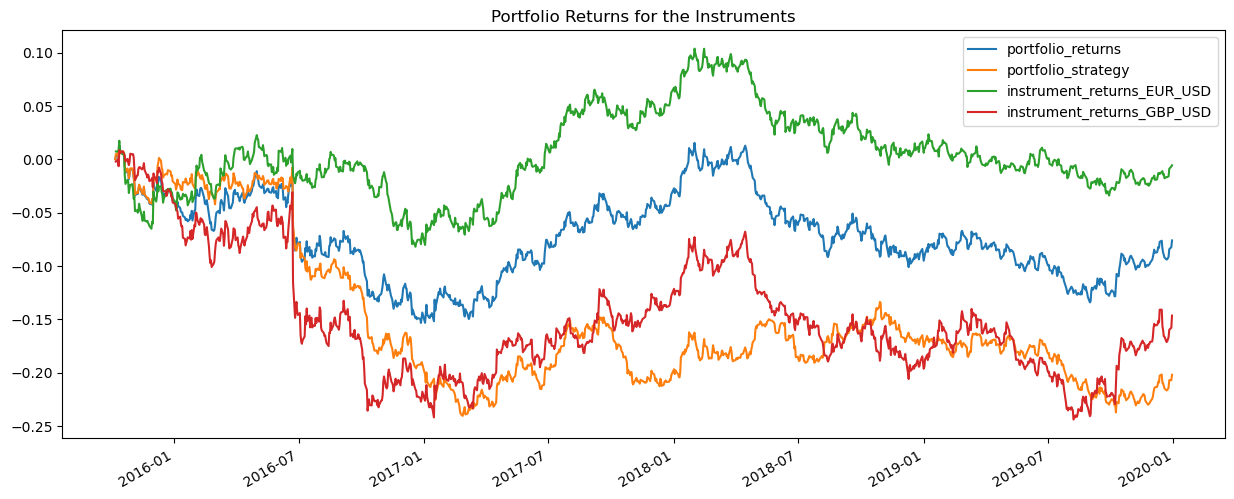

In [54]:
instruments_lis = ["EUR_USD","GBP_USD"]
params = {
    "from": "2015-01-01T00:00:00Z",  # 开始时间
    "to": "2019-12-31T23:59:59Z",  # 结束时间
    "granularity": "D"  # 日线数据
}


results = pd.DataFrame()

for instrument in instruments_lis:
    print('-------------------')
    print('Running the Strategy for:', instrument)
    print('-------------------')
    momentum_hurst_rsi = Momentum_Hurst_RSI(instrument, params, 5, 21, 200)
    momentum_hurst_rsi.strategy()
    results['instrument_returns_'+instrument]=momentum_hurst_rsi.visualise_data['Instrument_Returns']
    results['strategy_returns_'+ instrument] = momentum_hurst_rsi.visualise_data['Strategy_Returns']

instrument_returns = results.filter(like='instrument')
strategy_returns = results.filter(like='strategy')


results['portfolio_returns'] = instrument_returns.sum(axis=1) / len(instruments_lis)
results['portfolio_strategy'] = strategy_returns.sum(axis=1) / len(instruments_lis)

plot_title = 'Portfolio Returns for the Instruments'
columns_to_plot = ['portfolio_returns', 'portfolio_strategy'] + ['instrument_returns_' + instrument for instrument in instruments_lis]
results[columns_to_plot].cumsum().plot(title=plot_title, figsize=(15, 6))

calculate_metrics(results['portfolio_returns'], 'Portfolio Returns')
calculate_metrics(results['portfolio_strategy'], 'Portfolio Strategy')




## 调参

In [ ]:
# Function to calculate annual return, annual standard deviation and Sharpe ratio for multiple stocks
def run_strategy_and_analyze(instruments_lis, params, short_window, long_window, hurst_window):
    results = pd.DataFrame() # create an empty dataframe to store the results

    for instrument in instruments_lis:
        momentum_hurst_rsi = Momentum_Hurst_RSI(instrument,params, short_window, long_window, hurst_window)
        momentum_hurst_rsi.strategy()
        results['instrument_returns_'+ instrument] = momentum_hurst_rsi.visualise_data['Instrument_Returns']
        results['strategy_returns_'+ instrument] = momentum_hurst_rsi.visualise_data['Strategy_Returns']
    # calculate the portfolio returns and strategy returns
    instrument_returns = results.filter(like='instrument')
    strategy_returns = results.filter(like='strategy')

    results['portfolio_returns'] = instrument_returns.sum(axis=1) / len(instruments_lis) # average of the stock returns
    results['portfolio_strategy'] = strategy_returns.sum(axis=1) / len(instruments_lis) # average of the strategy returns

    plot_title = 'Portfolio Returns for the Instruments'
    columns_to_plot = ['portfolio_returns', 'portfolio_strategy'] + ['instrument_returns_' + instrument for instrument in instruments_lis]
    results[columns_to_plot].cumsum().plot(title=plot_title, figsize=(15, 6))

    calculate_metrics(results['portfolio_returns'], 'Portfolio Returns')
    calculate_metrics(results['portfolio_strategy'], 'Portfolio Strategy')

    return results

Annual Regular Return (Portfolio Returns): -0.017323491896074517
Annual Regular Standard Deviation (Portfolio Returns): 0.07551841849026417
Sharpe Ratio (Portfolio Returns): -0.22939426225282858
Annual Regular Return (Portfolio Strategy): -0.045320847934564146
Annual Regular Standard Deviation (Portfolio Strategy): 0.06902831434735822
Sharpe Ratio (Portfolio Strategy): -0.6565544641073597


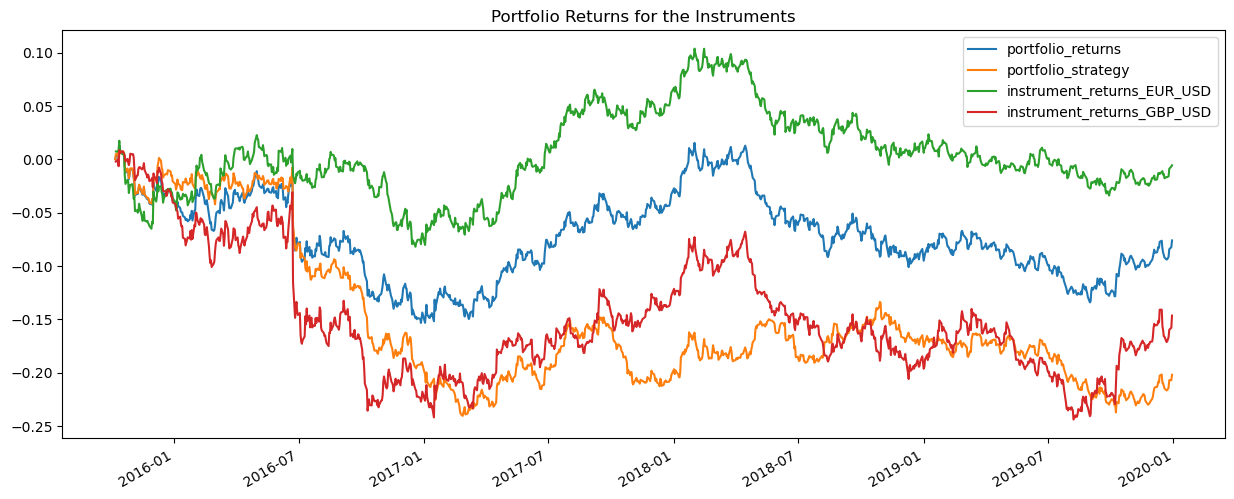

In [ ]:
# Encapsulated function call， to run the strategy and analyze the results
instruments_lis = ['EUR_USD', 'GBP_USD']
params = {
    "from": "2015-01-01T00:00:00Z",  # 开始时间
    "to": "2019-12-31T23:59:59Z",  # 结束时间
    "granularity": "D"  # 日线数据
}

short_window = 5
long_window = 21
hurst_window = 200

results2 = run_strategy_and_analyze(instruments_lis, params, short_window, long_window, hurst_window=200)

-------------------
Running the Strategy for Short Window: 60
-------------------
Annual Regular Return (Portfolio Returns): -0.017323491896074517
Annual Regular Standard Deviation (Portfolio Returns): 0.07551841849026417
Sharpe Ratio (Portfolio Returns): -0.22939426225282858
Annual Regular Return (Portfolio Strategy): -0.057095805677943146
Annual Regular Standard Deviation (Portfolio Strategy): 0.06762381832433367
Sharpe Ratio (Portfolio Strategy): -0.8443150223210312
-------------------
Running the Strategy for Short Window: 65
-------------------
Annual Regular Return (Portfolio Returns): -0.017323491896074517
Annual Regular Standard Deviation (Portfolio Returns): 0.07551841849026417
Sharpe Ratio (Portfolio Returns): -0.22939426225282858
Annual Regular Return (Portfolio Strategy): -0.06642595842212251
Annual Regular Standard Deviation (Portfolio Strategy): 0.06730450589580358
Sharpe Ratio (Portfolio Strategy): -0.986946676719666
-------------------
Running the Strategy for Short Win

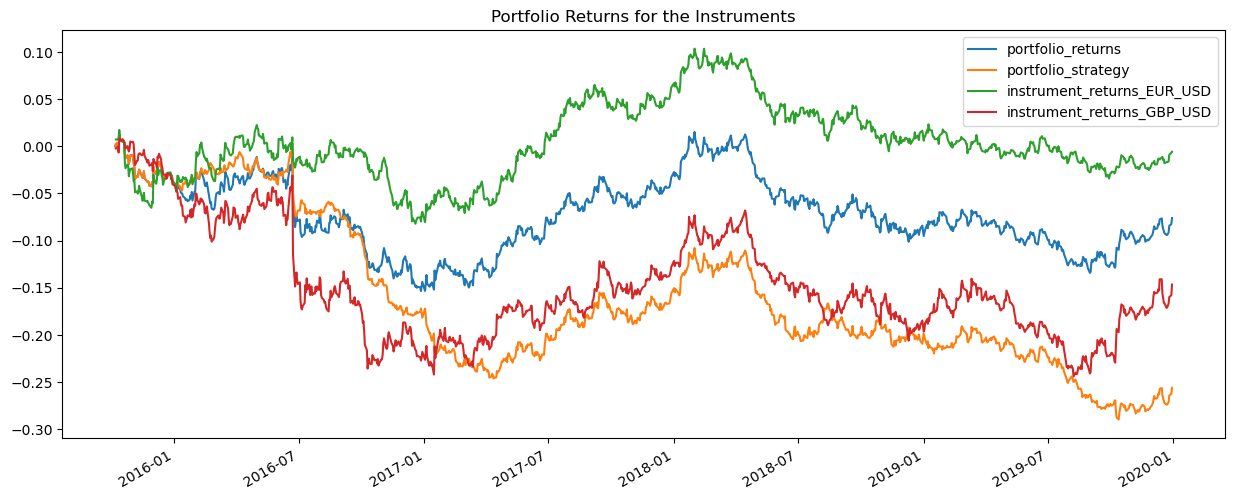

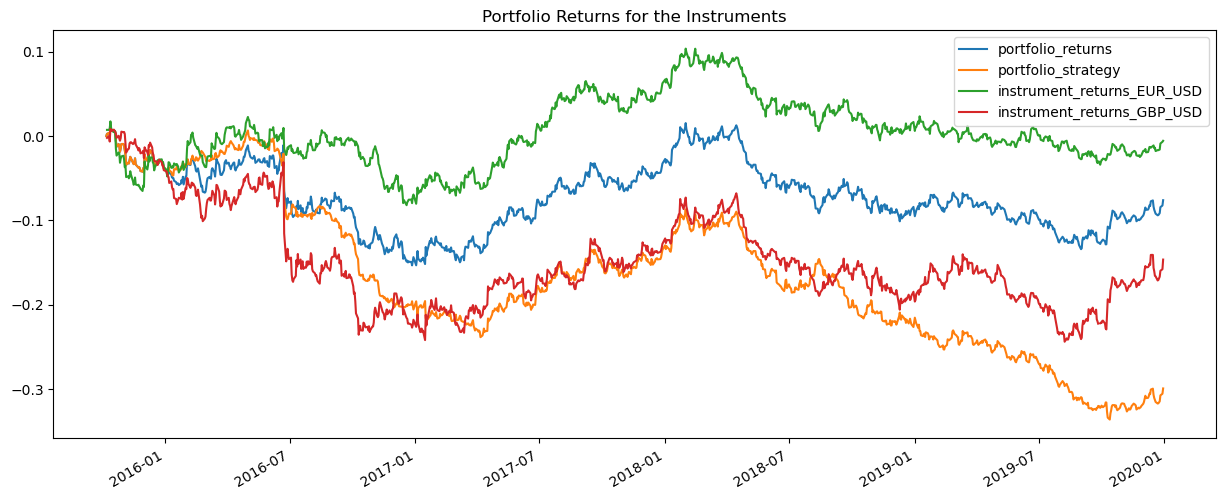

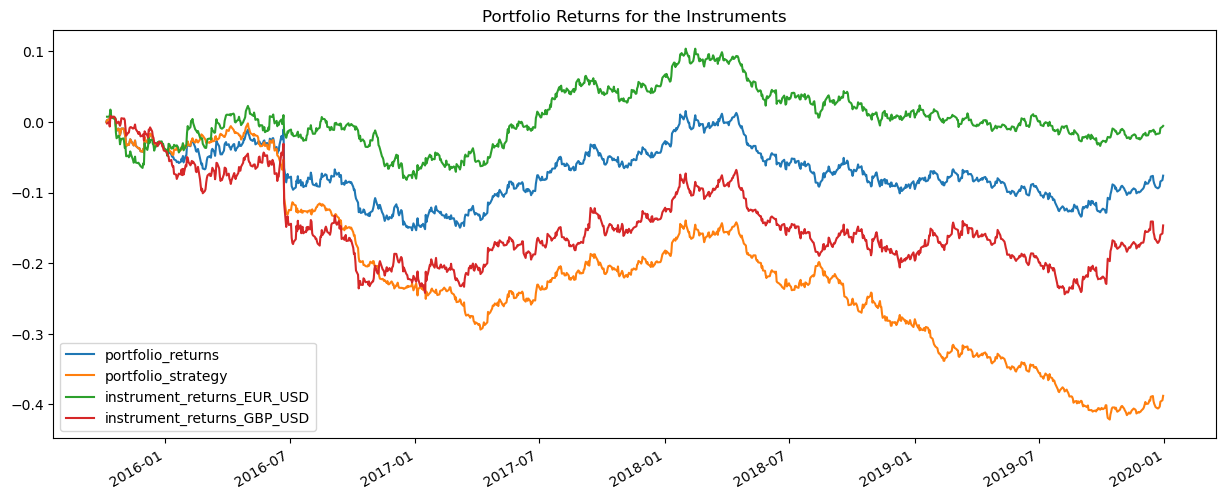

In [ ]:
# Tune the parameters for the strategy, start with the short term window

for short_window in range(60,75 , 5):
    print('-------------------')
    print('Running the Strategy for Short Window:', short_window)
    print('-------------------')
    results2 = run_strategy_and_analyze(instruments_lis, params, short_window, long_window=150, hurst_window=200)

## Comment

Based on our analysis, it appears that a window parameter value of 65 is the most optimal for short-term results. We will save these findings and proceed to evaluate additional parameters.

-------------------
Running the Strategy for Long Window: 78
-------------------
Annual Regular Return (Portfolio Returns): -0.017323491896074517
Annual Regular Standard Deviation (Portfolio Returns): 0.07551841849026417
Sharpe Ratio (Portfolio Returns): -0.22939426225282858
Annual Regular Return (Portfolio Strategy): -0.05870478067422147
Annual Regular Standard Deviation (Portfolio Strategy): 0.06711741170388602
Sharpe Ratio (Portfolio Strategy): -0.8746579938633499
-------------------
Running the Strategy for Long Window: 80
-------------------
Annual Regular Return (Portfolio Returns): -0.017323491896074517
Annual Regular Standard Deviation (Portfolio Returns): 0.07551841849026417
Sharpe Ratio (Portfolio Returns): -0.22939426225282858
Annual Regular Return (Portfolio Strategy): -0.055389341680886606
Annual Regular Standard Deviation (Portfolio Strategy): 0.06701065734013659
Sharpe Ratio (Portfolio Strategy): -0.8265751132650164
-------------------
Running the Strategy for Long Windo

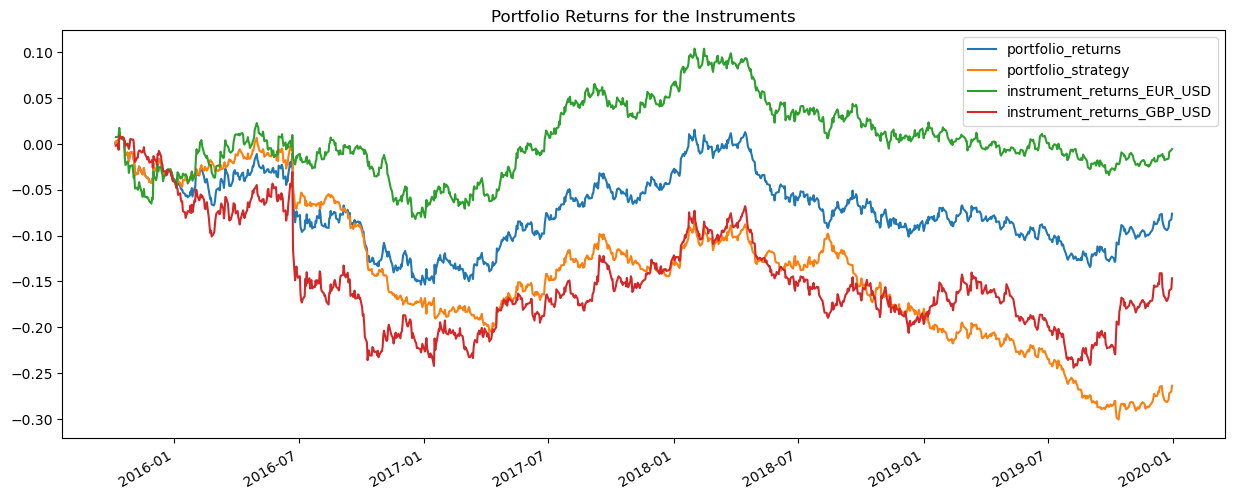

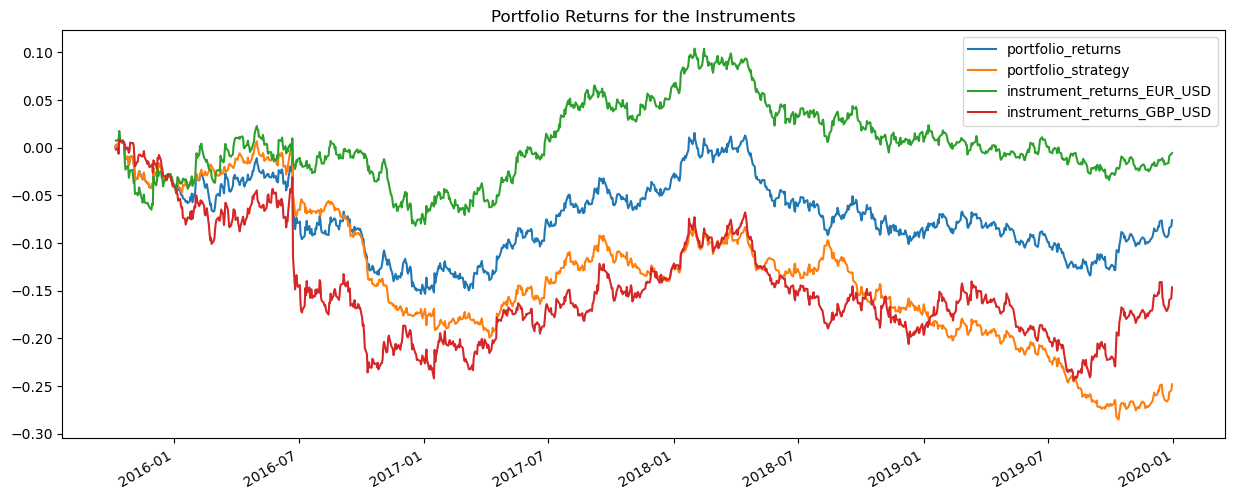

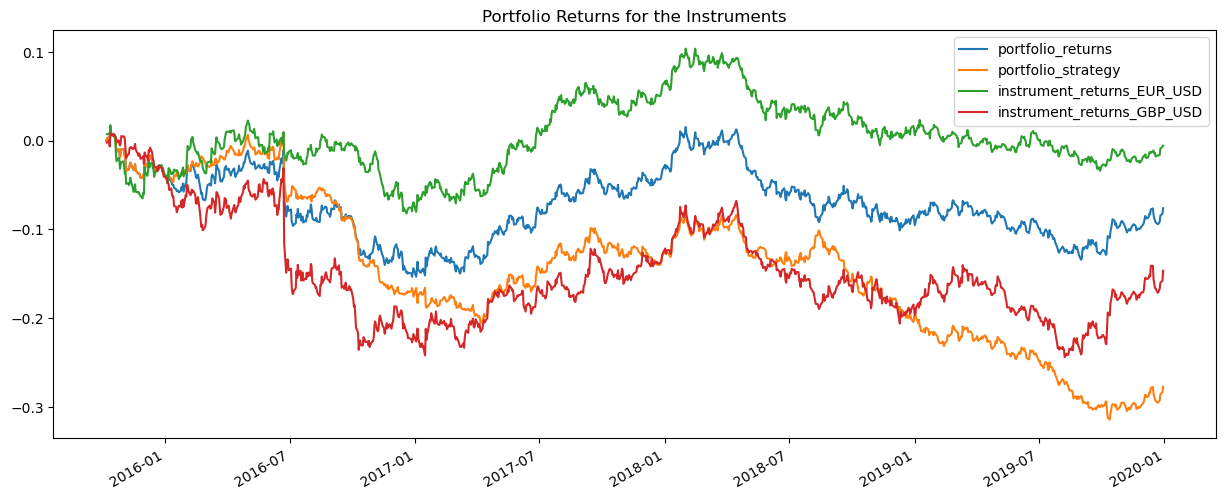

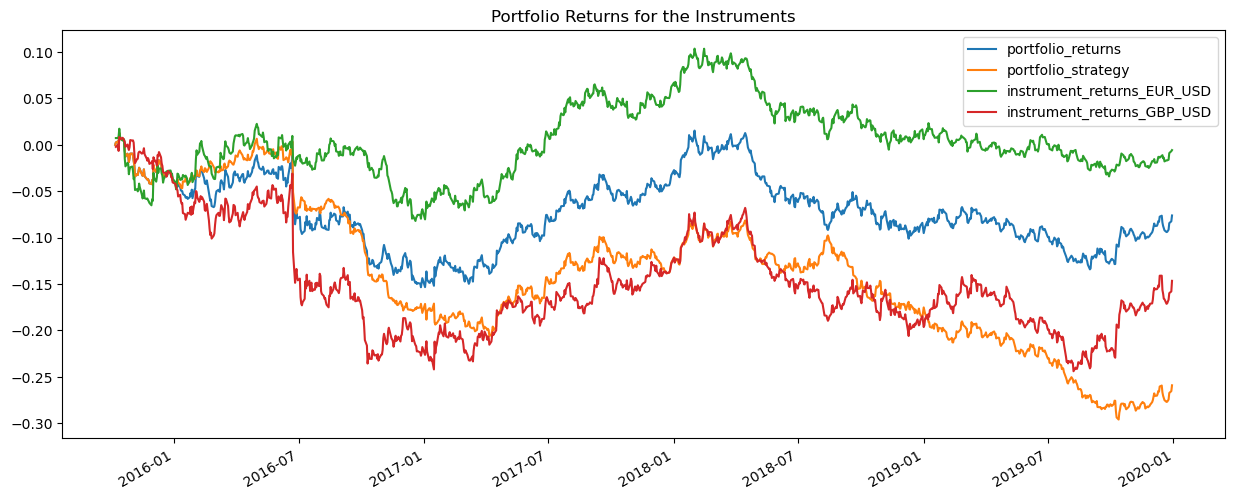

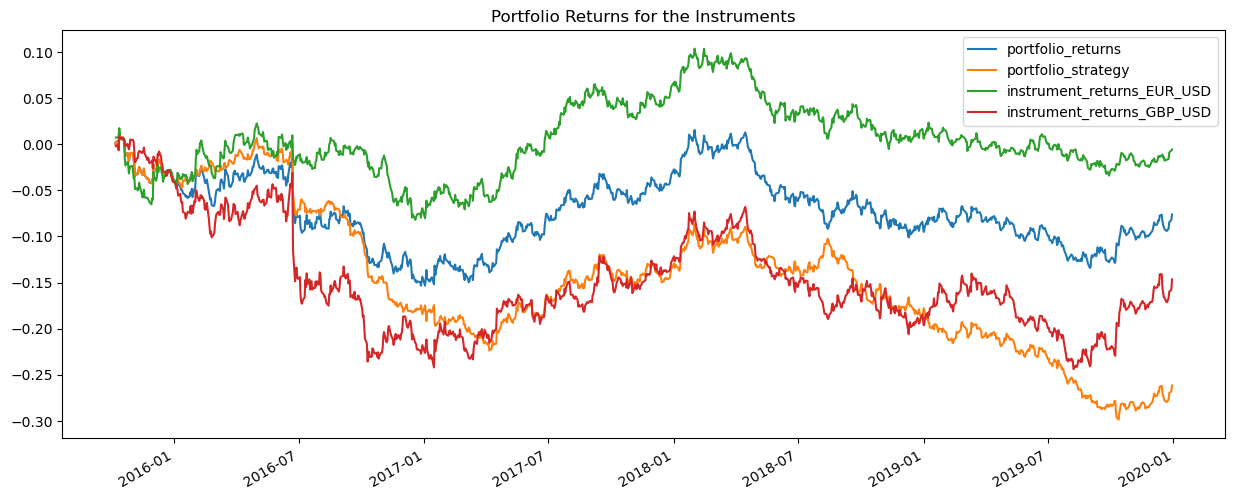

In [ ]:
# Tune the parameters for the strategy, continue with the long term window
short_window = 65

for long_window in range(78, 88, 2):
    print('-------------------')
    print('Running the Strategy for Long Window:', long_window)
    print('-------------------')
    results2 = run_strategy_and_analyze(instruments_lis,params, short_window, long_window, hurst_window=200)

## Comment

Based on our analysis, it appears that a window parameter value of 80 is the most optimal for long-term results. We will save these findings and proceed to evaluate additional parameters.

-------------------
Running the Strategy for Hurst Window: 100
-------------------
Annual Regular Return (Portfolio Returns): -0.014393168438130322
Annual Regular Standard Deviation (Portfolio Returns): 0.07591298989427495
Sharpe Ratio (Portfolio Returns): -0.18960086354358963
Annual Regular Return (Portfolio Strategy): -0.02100097866049555
Annual Regular Standard Deviation (Portfolio Strategy): 0.0698467111060568
Sharpe Ratio (Portfolio Strategy): -0.30067240572869924
-------------------
Running the Strategy for Hurst Window: 200
-------------------
Annual Regular Return (Portfolio Returns): -0.017323491896074517
Annual Regular Standard Deviation (Portfolio Returns): 0.07551841849026417
Sharpe Ratio (Portfolio Returns): -0.22939426225282858
Annual Regular Return (Portfolio Strategy): -0.055389341680886606
Annual Regular Standard Deviation (Portfolio Strategy): 0.06701065734013659
Sharpe Ratio (Portfolio Strategy): -0.8265751132650164
-------------------
Running the Strategy for Hurst 

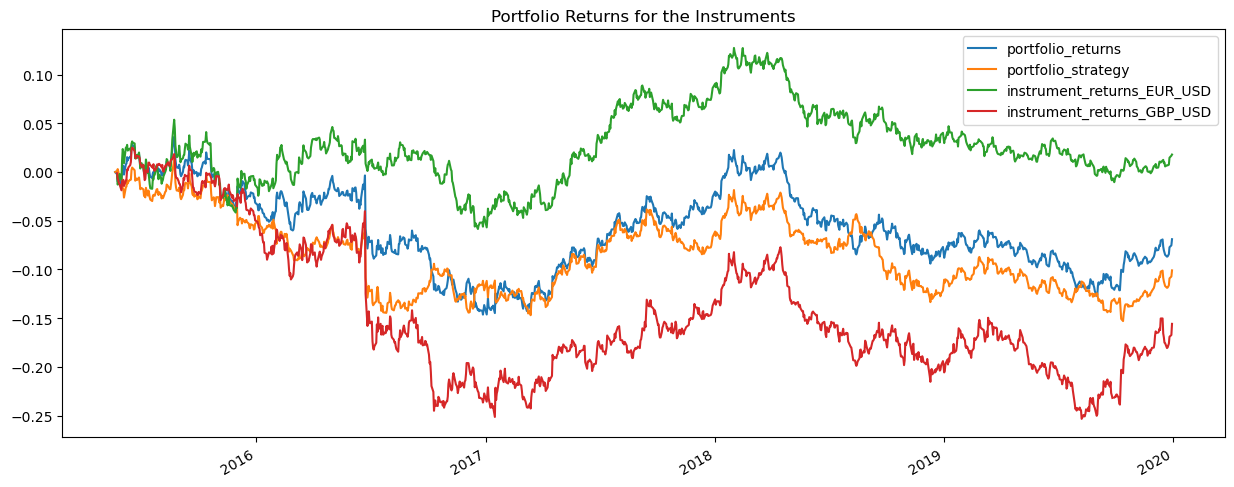

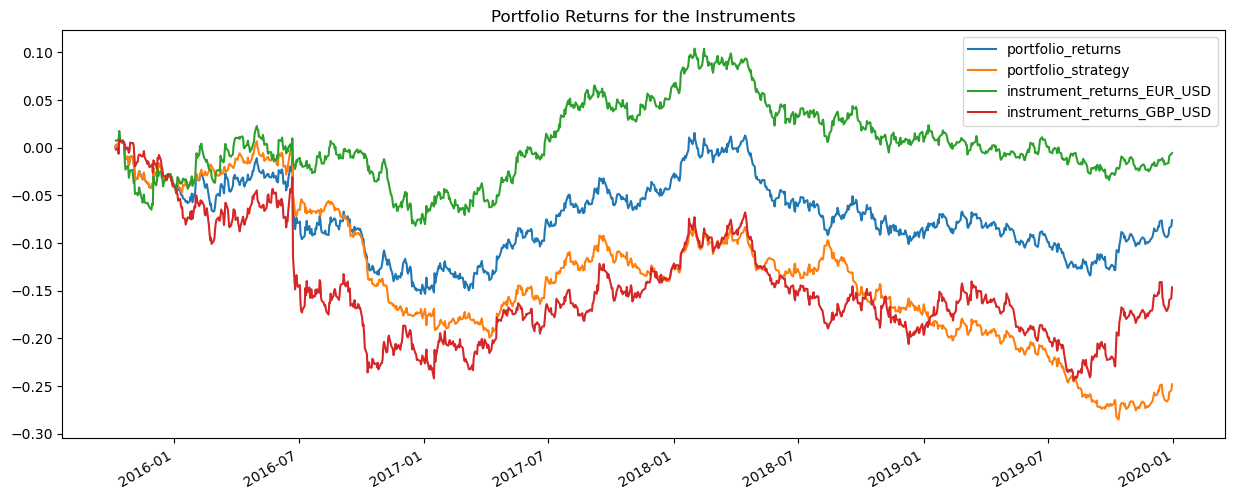

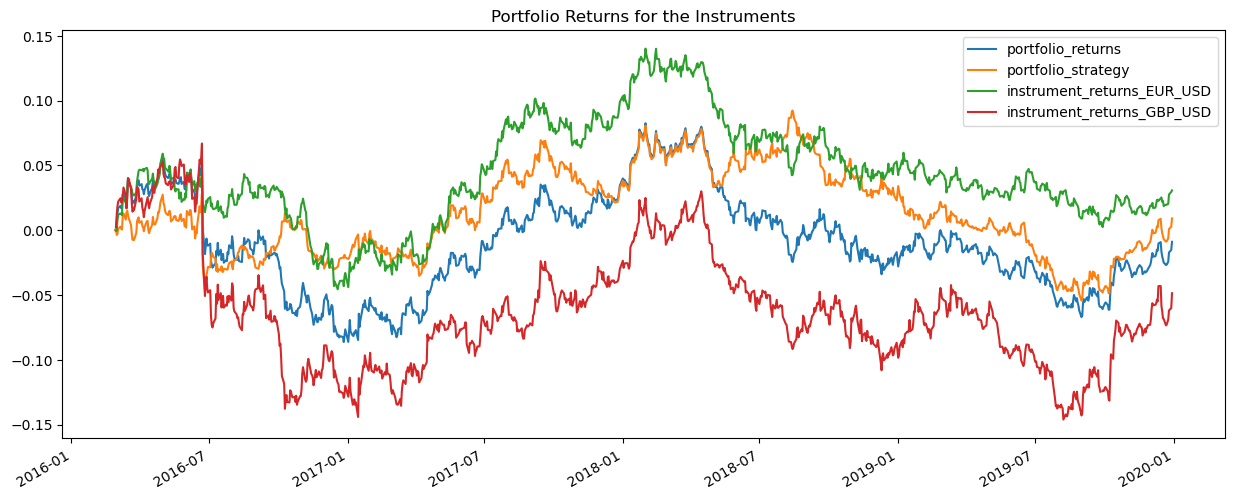

In [ ]:
# Tune the parameters for the strategy, continue with the Hurst window
short_window = 65
long_window = 80

for hurst_window in range(100, 301, 100):
    print('-------------------')
    print('Running the Strategy for Hurst Window:', hurst_window)
    print('-------------------')
    results2 = run_strategy_and_analyze(instruments_lis, params, short_window, long_window, hurst_window)

## Comment

Based on our analysis, it appears that a window parameter value of 300 is the most optimal for hurst_window results. 

## Conclusioin

We can get the best suitable combination for this strategy to get the best perfomance:

    short term window = 65,
    long term window = 80,
    hurst window = 300

# Backtest

-------------------
Running the Strategy for: EUR_USD
-------------------
-------------------
Running the Strategy for: GBP_USD
-------------------
Annual Regular Return (Portfolio Returns): -0.029819544801819475
Annual Regular Standard Deviation (Portfolio Returns): 0.08217916169202115
Sharpe Ratio (Portfolio Returns): -0.3628601726745855
Annual Regular Return (Portfolio Strategy): -0.013560180652579579
Annual Regular Standard Deviation (Portfolio Strategy): 0.0773757316257089
Sharpe Ratio (Portfolio Strategy): -0.1752510815429119


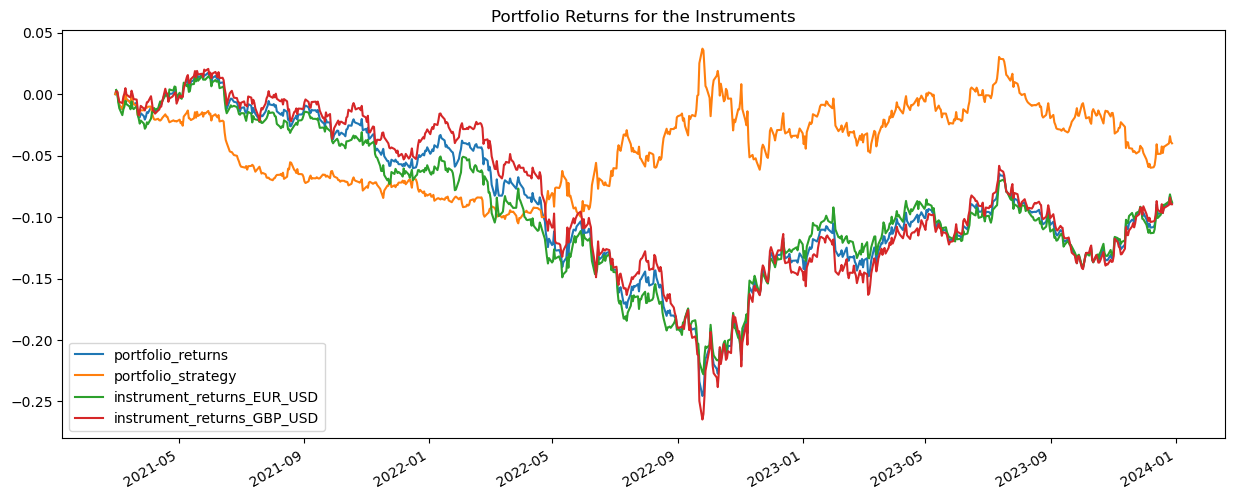

In [ ]:
instruments_lis = ["EUR_USD","GBP_USD"]
bt_params = {
    "from": "2020-01-01T00:00:00Z",  # 开始时间
    "to": "2023-12-31T23:59:59Z",  # 结束时间
    "granularity": "D"  # 日线数据
}


bt_results = pd.DataFrame()

for instrument in instruments_lis:
    print('-------------------')
    print('Running the Strategy for:', instrument)
    print('-------------------')
    momentum_hurst_rsi = Momentum_Hurst_RSI(instrument, bt_params, 65, 80, 300)
    momentum_hurst_rsi.strategy()
    bt_results['instrument_returns_'+instrument]=momentum_hurst_rsi.visualise_data['Instrument_Returns']
    bt_results['strategy_returns_'+ instrument] = momentum_hurst_rsi.visualise_data['Strategy_Returns']

bt_instrument_returns = bt_results.filter(like='instrument')
bt_strategy_returns = bt_results.filter(like='strategy')


bt_results['portfolio_returns'] = bt_instrument_returns.sum(axis=1) / len(instruments_lis)
bt_results['portfolio_strategy'] = bt_strategy_returns.sum(axis=1) / len(instruments_lis)

plot_title = 'Portfolio Returns for the Instruments'
columns_to_plot = ['portfolio_returns', 'portfolio_strategy'] + ['instrument_returns_' + instrument for instrument in instruments_lis]
bt_results[columns_to_plot].cumsum().plot(title=plot_title, figsize=(15, 6))

calculate_metrics(bt_results['portfolio_returns'], 'Portfolio Returns')
calculate_metrics(bt_results['portfolio_strategy'], 'Portfolio Strategy')


# 策略调整

通过纵向对比策略2在测试集和训练集上的表现，横向对比策略1和策略2在相同历史时间段的表现可以发现：策略1在市场出现横盘波动时能取得稳定优秀的表现，策略2在市场出现持续明显趋势时能够取得可观的回报，对比两个策略的实现方式，提出以下修正思路：

1. 因为策略2是从stock market迁移到FX market，所以内部RSI指标使用的根据历史数据得出的30/70度量可能需要调整
2. 策略2的思路是使用Hurst指标来检测市场价格变化的预测性，>0.5显示出持久性，<0.5显示出非持久性，那么延伸出两个方向
    1. \>0.5是按照动量指导long/short，那么<0.5时，也可以依据动量反向知道long/short
    1. 转换思路，在Hurst接近1时依照动量指导long/short，Hurst接近0时依照动量反向知道long/short，然后使用RSI指标处理横盘波动
3. 策略1使用的BB和策略2使用的RSI都是类似的思路，通过判断当前价格在历史价格中所处的位置来决定long/short，那么可以考虑使用策略1中的BB代替RSI判断是否取得更好的效果
4. 进行定量分析，回归单一指标，测定哪一策略思路在哪一市场变现下会取得更好的表现，再进行整合。

## Step 1 RSI Adjustment

Try 60/80 or 10/20/30 performance

RSI = 70:  
Annual Regular Return (Portfolio Returns): -0.017323491896074517  
Annual Regular Standard Deviation (Portfolio Returns): 0.07551841849026418  
Sharpe Ratio (Portfolio Returns): -0.22939426225282852  
Annual Regular Return (Portfolio Strategy): -0.045320847934564146  
Annual Regular Standard Deviation (Portfolio Strategy): 0.06902831434735822  
Sharpe Ratio (Portfolio Strategy): -0.6565544641073597  


RSI = 80:  
Annual Regular Return (Portfolio Returns): -0.017323491896074517  
Annual Regular Standard Deviation (Portfolio Returns): 0.07551841849026418  
Sharpe Ratio (Portfolio Returns): -0.22939426225282852  
Annual Regular Return (Portfolio Strategy): -0.048029562850259166  
Annual Regular Standard Deviation (Portfolio Strategy): 0.07016450520321137  
Sharpe Ratio (Portfolio Strategy): -0.6845279206509803  

RSI = 60:  significant improvement, but still negative return  
Annual Regular Return (Portfolio Returns): -0.017323491896074517  
Annual Regular Standard Deviation (Portfolio Returns): 0.07551841849026418  
Sharpe Ratio (Portfolio Returns): -0.2293942622528285  
Annual Regular Return (Portfolio Strategy): -0.022545138364799433  
Annual Regular Standard Deviation (Portfolio Strategy): 0.06271705235769903  
Sharpe Ratio (Portfolio Strategy): -0.3594738195956021  

RSI = 55: performance become worse
Annual Regular Return (Portfolio Returns): -0.017323491896074517  
Annual Regular Standard Deviation (Portfolio Returns): 0.07551841849026418  
Sharpe Ratio (Portfolio Returns): -0.22939426225282852  
Annual Regular Return (Portfolio Strategy): -0.024127732618090758  
Annual Regular Standard Deviation (Portfolio Strategy): 0.062169044501230265  
Sharpe Ratio (Portfolio Strategy): -0.38809881688970294  

Take 60 as most suitable RSI dividing line, question: is that reasonable? or overfitting for the specifit market movement?

In [ ]:
class Momentum_Hurst_RSI_2():

    def __init__(self, instrument, params, short_term_window, long_term_window, hurst_window ): # params: from, to, granularity
        self.instrument = instrument
        self.params = params
        self.ST_window = short_term_window
        self.LT_window = long_term_window
        # Hurst exponent
        self.hurst_window = hurst_window

        # RSI indicator, same as the short term window
        self.RSI_window = short_term_window
        self.prepare_data()
    

    def prepare_data(self):
        # Make a request
        r = instruments.InstrumentsCandles(instrument=self.instrument, params=self.params)
        data = api.request(r)

        # Extract date and closing price and form as a DataFrame
        dates = [candle['time'][:10] for candle in data['candles']]  # Intercept the first 10 characters to get the date
        close_prices = [float(candle['mid']['c']) for candle in data['candles']]  # Get Close Price

        # Create DataFrame, row_index: date; column: close price
        bt_data = pd.DataFrame(data=close_prices, index=pd.to_datetime(dates), columns=['Close_Price'])


        # Calculate the momentum and the Hurst exponent
        bt_data['ShortTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.ST_window)
        bt_data['LongTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.LT_window)    
        bt_data['Hurst'] = bt_data['Close_Price'].rolling(window=self.hurst_window).apply(lambda x: compute_Hc(x)[0])

        # Calculating the RSI
        rsi_indicator = RSIIndicator(close = bt_data['Close_Price'], window = self.RSI_window, fillna = False)
        RSI = rsi_indicator.rsi()

        # Adding the RSI to the dataframe
        bt_data['RSI'] = RSI

        bt_data = bt_data.dropna()
        self.data = bt_data
        
    def strategy(self):
        
        data = self.data
         
        # data['Position'] = 1
        data.loc[(data['Hurst'] > 0.5) & (data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] > 0), 'Position'] = 1 # Hurst exponent greater than 0.5, short term and long term momentum greater than 0, buy
        data.loc[(data['Hurst'] > 0.5) & (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] < 0), 'Position'] = -1

        # Out of the market, RSI less than 80
        # data.loc[(data['RSI'] <= 80) & (data['Hurst'] > 0.5) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = 1
        # data.loc[(data['RSI'] > 80) & (data['Hurst'] > 0.5) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = -1
        # data.loc[(data['Hurst'] < 0.5) & (data['RSI'] <= 80), 'Position'] = 1
        # data.loc[(data['Hurst'] < 0.5) & (data['RSI'] > 80), 'Position'] = -1

        # Out of the market, RSI less than 70
        # data.loc[(data['RSI'] <= 70) & (data['Hurst'] > 0.5) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = 1
        # data.loc[(data['RSI'] > 70) & (data['Hurst'] > 0.5) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = -1
        # data.loc[(data['Hurst'] < 0.5) & (data['RSI'] <= 70), 'Position'] = 1
        # data.loc[(data['Hurst'] < 0.5) & (data['RSI'] > 70), 'Position'] = -1

        # Out of the market, RSI less than 60
        data.loc[(data['RSI'] <= 60) & (data['Hurst'] > 0.5) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = 1
        data.loc[(data['RSI'] > 60) & (data['Hurst'] > 0.5) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = -1
        data.loc[(data['Hurst'] < 0.5) & (data['RSI'] <= 60), 'Position'] = 1
        data.loc[(data['Hurst'] < 0.5) & (data['RSI'] > 60), 'Position'] = -1

        # Out of the market, RSI less than 55
        # data.loc[(data['RSI'] <= 55) & (data['Hurst'] > 0.5) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = 1
        # data.loc[(data['RSI'] > 55) & (data['Hurst'] > 0.5) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = -1
        # data.loc[(data['Hurst'] < 0.5) & (data['RSI'] <= 55), 'Position'] = 1
        # data.loc[(data['Hurst'] < 0.5) & (data['RSI'] > 55), 'Position'] = -1

        data['Signal'] = data['Position'].diff()
        data = data.dropna()

        data['Instrument_Returns'] = np.log(data['Close_Price']/data['Close_Price'].shift(1))
        data['Strategy_Returns'] = data['Instrument_Returns'] * data['Position'].shift(1)

        self.visualise_data = data
    

-------------------
Running the Strategy for: EUR_USD
-------------------
-------------------
Running the Strategy for: GBP_USD
-------------------
Annual Regular Return (Portfolio Returns): -0.017323491896074517
Annual Regular Standard Deviation (Portfolio Returns): 0.07551841849026418
Sharpe Ratio (Portfolio Returns): -0.22939426225282852
Annual Regular Return (Portfolio Strategy): -0.022545138364799433
Annual Regular Standard Deviation (Portfolio Strategy): 0.06271705235769903
Sharpe Ratio (Portfolio Strategy): -0.3594738195956021


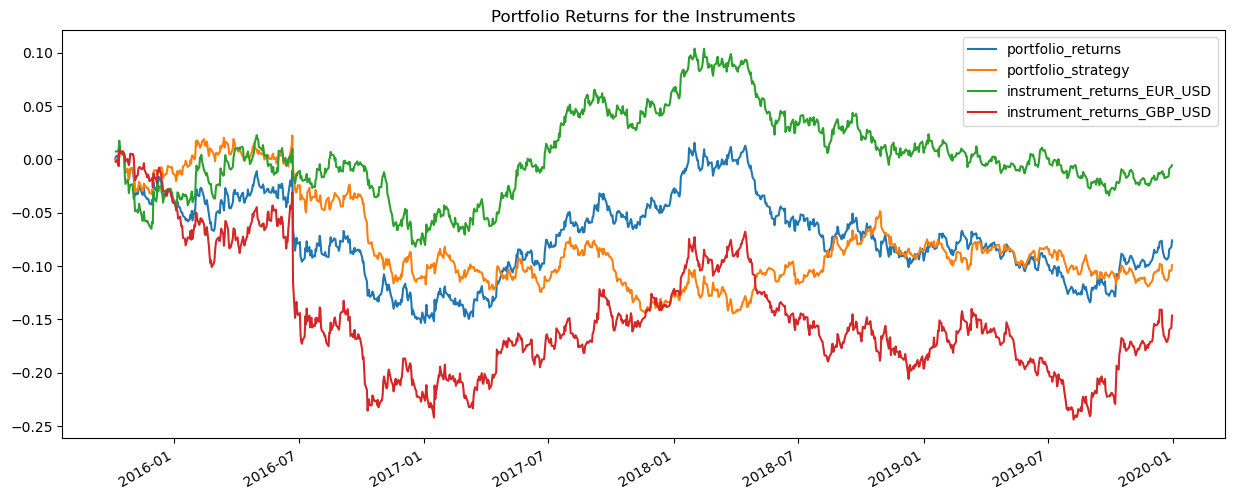

In [ ]:
instruments_lis = ["EUR_USD","GBP_USD"]
params = {
    "from": "2015-01-01T00:00:00Z",  # 开始时间
    "to": "2019-12-31T23:59:59Z",  # 结束时间
    "granularity": "D"  # 日线数据
}


results = pd.DataFrame()

for instrument in instruments_lis:
    print('-------------------')
    print('Running the Strategy for:', instrument)
    print('-------------------')
    momentum_hurst_rsi = Momentum_Hurst_RSI_2(instrument, params, 5, 21, 200)
    momentum_hurst_rsi.strategy()
    results['instrument_returns_'+instrument]=momentum_hurst_rsi.visualise_data['Instrument_Returns']
    results['strategy_returns_'+ instrument] = momentum_hurst_rsi.visualise_data['Strategy_Returns']

instrument_returns = results.filter(like='instrument')
strategy_returns = results.filter(like='strategy')


results['portfolio_returns'] = instrument_returns.sum(axis=1) / len(instruments_lis)
results['portfolio_strategy'] = strategy_returns.sum(axis=1) / len(instruments_lis)

plot_title = 'Portfolio Returns for the Instruments'
columns_to_plot = ['portfolio_returns', 'portfolio_strategy'] + ['instrument_returns_' + instrument for instrument in instruments_lis]
results[columns_to_plot].cumsum().plot(title=plot_title, figsize=(15, 6))

calculate_metrics(results['portfolio_returns'], 'Portfolio Returns')
calculate_metrics(results['portfolio_strategy'], 'Portfolio Strategy')

-------------------
Running the Strategy for: EUR_USD
-------------------
-------------------
Running the Strategy for: GBP_USD
-------------------
Annual Regular Return (Portfolio Returns): -0.011879687235971548
Annual Regular Standard Deviation (Portfolio Returns): 0.080093828970179
Sharpe Ratio (Portfolio Returns): -0.14832212904185993
Annual Regular Return (Portfolio Strategy): 0.016944956764626706
Annual Regular Standard Deviation (Portfolio Strategy): 0.06845585040111603
Sharpe Ratio (Portfolio Strategy): 0.2475311703139759


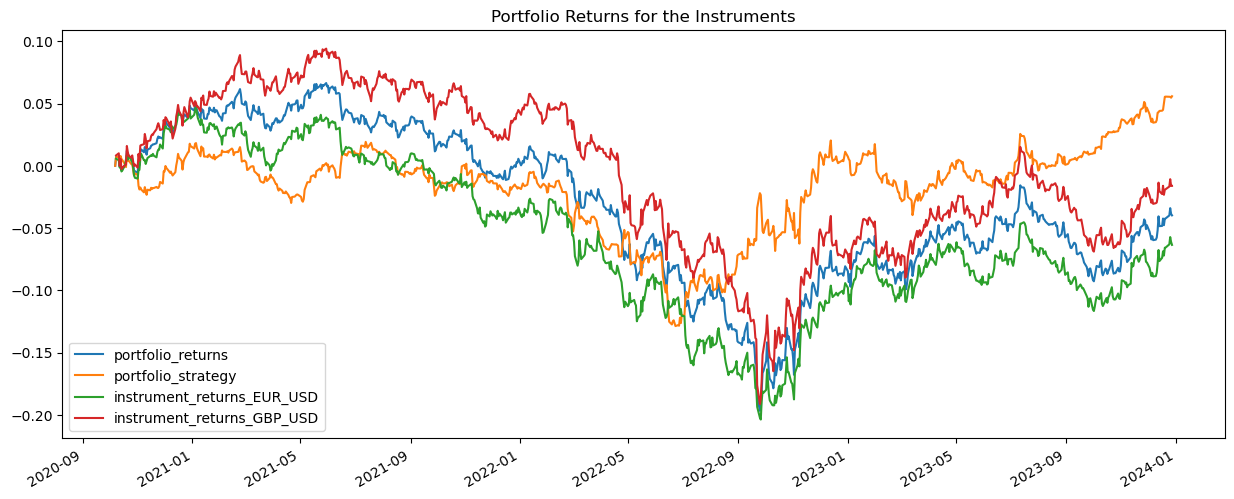

In [ ]:
instruments_lis = ["EUR_USD","GBP_USD"]
bt_params = {
    "from": "2020-01-01T00:00:00Z",  # 开始时间
    "to": "2023-12-31T23:59:59Z",  # 结束时间
    "granularity": "D"  # 日线数据
}


bt_results = pd.DataFrame()

for instrument in instruments_lis:
    print('-------------------')
    print('Running the Strategy for:', instrument)
    print('-------------------')
    momentum_hurst_rsi = Momentum_Hurst_RSI_2(instrument, bt_params, 5, 21, 200)
    momentum_hurst_rsi.strategy()
    bt_results['instrument_returns_'+instrument]=momentum_hurst_rsi.visualise_data['Instrument_Returns']
    bt_results['strategy_returns_'+ instrument] = momentum_hurst_rsi.visualise_data['Strategy_Returns']

bt_instrument_returns = bt_results.filter(like='instrument')
bt_strategy_returns = bt_results.filter(like='strategy')


bt_results['portfolio_returns'] = bt_instrument_returns.sum(axis=1) / len(instruments_lis)
bt_results['portfolio_strategy'] = bt_strategy_returns.sum(axis=1) / len(instruments_lis)

plot_title = 'Portfolio Returns for the Instruments'
columns_to_plot = ['portfolio_returns', 'portfolio_strategy'] + ['instrument_returns_' + instrument for instrument in instruments_lis]
bt_results[columns_to_plot].cumsum().plot(title=plot_title, figsize=(15, 6))

calculate_metrics(bt_results['portfolio_returns'], 'Portfolio Returns')
calculate_metrics(bt_results['portfolio_strategy'], 'Portfolio Strategy')

## Step 2 Hurst Indicator Different Uses
a. Use Hurst and Momentum, only use RSI to deal with the confilict situation, i.e. long/short term momentum has oppsite results.  

Annual Regular Return (Portfolio Returns): -0.017323491896074517  
Annual Regular Standard Deviation (Portfolio Returns): 0.07551841849026418  
Sharpe Ratio (Portfolio Returns): -0.22939426225282852  
Annual Regular Return (Portfolio Strategy): -0.02485238724788741  
Annual Regular Standard Deviation (Portfolio Strategy): 0.06140563242874037  
Sharpe Ratio (Portfolio Strategy): -0.4047248805185413  

worse than former strategy when RSI more useful, does that mean momentum working worse than rsi?
Consideration: delete Momentum, Use hurst and rsi only

In [ ]:
class Momentum_Hurst_RSI_3():

    def __init__(self, instrument, params, short_term_window, long_term_window, hurst_window ): # params: from, to, granularity
        self.instrument = instrument
        self.params = params
        self.ST_window = short_term_window
        self.LT_window = long_term_window
        # Hurst exponent
        self.hurst_window = hurst_window

        # RSI indicator, same as the short term window
        self.RSI_window = short_term_window
        self.prepare_data()
    

    def prepare_data(self):
        # Make a request
        r = instruments.InstrumentsCandles(instrument=self.instrument, params=self.params)
        data = api.request(r)

        # Extract date and closing price and form as a DataFrame
        dates = [candle['time'][:10] for candle in data['candles']]  # Intercept the first 10 characters to get the date
        close_prices = [float(candle['mid']['c']) for candle in data['candles']]  # Get Close Price

        # Create DataFrame, row_index: date; column: close price
        bt_data = pd.DataFrame(data=close_prices, index=pd.to_datetime(dates), columns=['Close_Price'])


        # Calculate the momentum and the Hurst exponent
        bt_data['ShortTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.ST_window)
        bt_data['LongTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.LT_window)    
        bt_data['Hurst'] = bt_data['Close_Price'].rolling(window=self.hurst_window).apply(lambda x: compute_Hc(x)[0])

        # Calculating the RSI
        rsi_indicator = RSIIndicator(close = bt_data['Close_Price'], window = self.RSI_window, fillna = False)
        RSI = rsi_indicator.rsi()

        # Adding the RSI to the dataframe
        bt_data['RSI'] = RSI

        bt_data = bt_data.dropna()
        self.data = bt_data
        
    def strategy(self):
        
        data = self.data
         
        # data['Position'] = 1
        data.loc[(data['Hurst'] > 0.5) & (data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] > 0), 'Position'] = 1 # Hurst exponent greater than 0.5, short term and long term momentum greater than 0, buy
        data.loc[(data['Hurst'] > 0.5) & (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] < 0), 'Position'] = -1

        # Out of the market, RSI less than 60
        data.loc[(data['RSI'] <= 60) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = 1
        data.loc[(data['RSI'] > 60) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = -1
        
        # data.loc[(data['Hurst'] < 0.5) & (data['RSI'] <= 60), 'Position'] = 1
        # data.loc[(data['Hurst'] < 0.5) & (data['RSI'] > 60), 'Position'] = -1

        # Hurst less than 0.5, opposite of the above
        data.loc[(data['Hurst'] < 0.5) & (data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] > 0), 'Position'] = -1 # Hurst exponent greater than 0.5, short term and long term momentum greater than 0, buy
        data.loc[(data['Hurst'] < 0.5) & (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] < 0), 'Position'] = 1

        data['Signal'] = data['Position'].diff()
        data = data.dropna()

        data['Instrument_Returns'] = np.log(data['Close_Price']/data['Close_Price'].shift(1))
        data['Strategy_Returns'] = data['Instrument_Returns'] * data['Position'].shift(1)

        self.visualise_data = data
    

-------------------
Running the Strategy for: EUR_USD
-------------------
-------------------
Running the Strategy for: GBP_USD
-------------------
Annual Regular Return (Portfolio Returns): -0.017323491896074517
Annual Regular Standard Deviation (Portfolio Returns): 0.07551841849026418
Sharpe Ratio (Portfolio Returns): -0.22939426225282852
Annual Regular Return (Portfolio Strategy): -0.02485238724788741
Annual Regular Standard Deviation (Portfolio Strategy): 0.06140563242874037
Sharpe Ratio (Portfolio Strategy): -0.4047248805185413


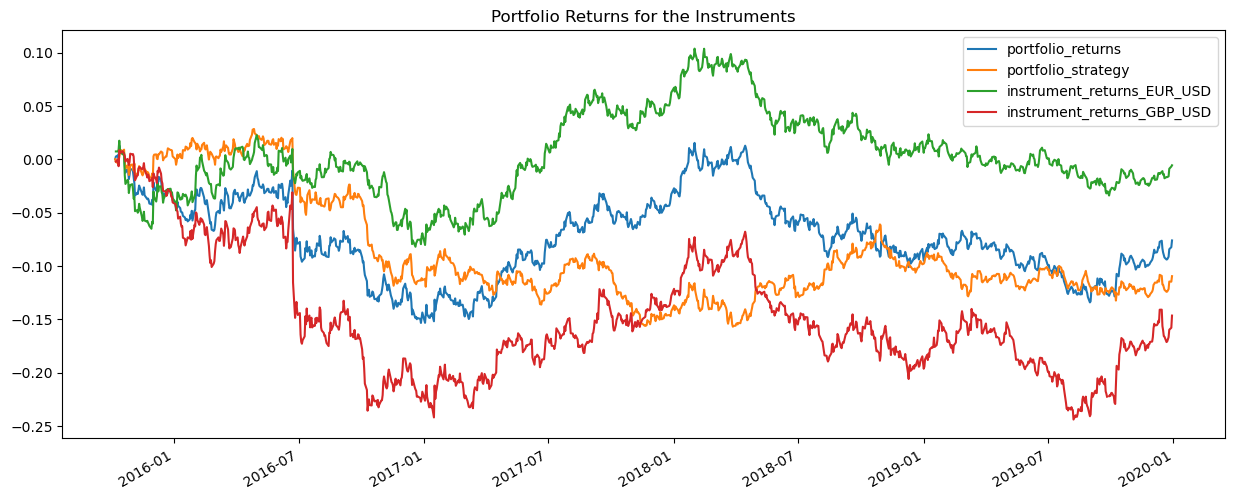

In [ ]:
instruments_lis = ["EUR_USD","GBP_USD"]
params = {
    "from": "2015-01-01T00:00:00Z",  # 开始时间
    "to": "2019-12-31T23:59:59Z",  # 结束时间
    "granularity": "D"  # 日线数据
}


results = pd.DataFrame()

for instrument in instruments_lis:
    print('-------------------')
    print('Running the Strategy for:', instrument)
    print('-------------------')
    momentum_hurst_rsi = Momentum_Hurst_RSI_3(instrument, params, 5, 21, 200)
    momentum_hurst_rsi.strategy()
    results['instrument_returns_'+instrument]=momentum_hurst_rsi.visualise_data['Instrument_Returns']
    results['strategy_returns_'+ instrument] = momentum_hurst_rsi.visualise_data['Strategy_Returns']

instrument_returns = results.filter(like='instrument')
strategy_returns = results.filter(like='strategy')


results['portfolio_returns'] = instrument_returns.sum(axis=1) / len(instruments_lis)
results['portfolio_strategy'] = strategy_returns.sum(axis=1) / len(instruments_lis)

plot_title = 'Portfolio Returns for the Instruments'
columns_to_plot = ['portfolio_returns', 'portfolio_strategy'] + ['instrument_returns_' + instrument for instrument in instruments_lis]
results[columns_to_plot].cumsum().plot(title=plot_title, figsize=(15, 6))

calculate_metrics(results['portfolio_returns'], 'Portfolio Returns')
calculate_metrics(results['portfolio_strategy'], 'Portfolio Strategy')

b. Hurst close to 1/0

In [56]:
class Momentum_Hurst_RSI_4():

    def __init__(self, instrument, params, short_term_window, long_term_window, hurst_window ): # params: from, to, granularity
        self.instrument = instrument
        self.params = params
        self.ST_window = short_term_window
        self.LT_window = long_term_window
        # Hurst exponent
        self.hurst_window = hurst_window

        # RSI indicator, same as the short term window
        self.RSI_window = short_term_window
        self.prepare_data()
    

    def prepare_data(self):
        # Make a request
        r = instruments.InstrumentsCandles(instrument=self.instrument, params=self.params)
        data = api.request(r)

        # Extract date and closing price and form as a DataFrame
        dates = [candle['time'][:10] for candle in data['candles']]  # Intercept the first 10 characters to get the date
        close_prices = [float(candle['mid']['c']) for candle in data['candles']]  # Get Close Price

        # Create DataFrame, row_index: date; column: close price
        bt_data = pd.DataFrame(data=close_prices, index=pd.to_datetime(dates), columns=['Close_Price'])


        # Calculate the momentum and the Hurst exponent
        bt_data['ShortTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.ST_window)
        bt_data['LongTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.LT_window)    
        bt_data['Hurst'] = bt_data['Close_Price'].rolling(window=self.hurst_window).apply(lambda x: compute_Hc(x)[0])

        # Calculating the RSI
        rsi_indicator = RSIIndicator(close = bt_data['Close_Price'], window = self.RSI_window, fillna = False)
        RSI = rsi_indicator.rsi()

        # Adding the RSI to the dataframe
        bt_data['RSI'] = RSI

        bt_data = bt_data.dropna()
        self.data = bt_data
        
    def strategy(self):
        
        data = self.data

        # add 0 to the position column
        data['Position'] = 0
         
        # data['Position'] = 1
        data.loc[(data['Hurst'] > 0.8) & (data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] > 0), 'Position'] = 1 # Hurst exponent greater than 0.5, short term and long term momentum greater than 0, buy
        data.loc[(data['Hurst'] > 0.8) & (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] < 0), 'Position'] = -1

        # Out of the market, RSI less than 60
        data.loc[(data['RSI'] <= 30) & (0.2 <= data['Hurst']) & (data['Hurst'] <= 0.8), 'Position'] = 1
        data.loc[(data['RSI'] > 70) & (0.2 <= data['Hurst']) & (data['Hurst'] <= 0.8), 'Position'] = -1

        # Hurst less than 0.5, opposite of the above
        data.loc[(data['Hurst'] < 0.2) & (data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] > 0), 'Position'] = -1 # Hurst exponent greater than 0.5, short term and long term momentum greater than 0, buy
        data.loc[(data['Hurst'] < 0.2) & (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] < 0), 'Position'] = 1

        

        data['Signal'] = data['Position'].diff()
        data = data.dropna()

        data['Instrument_Returns'] = np.log(data['Close_Price']/data['Close_Price'].shift(1))
        data['Strategy_Returns'] = data['Instrument_Returns'] * data['Position'].shift(1)

        self.visualise_data = data

-------------------
Running the Strategy for: EUR_USD
-------------------
-------------------
Running the Strategy for: GBP_USD
-------------------
Annual Regular Return (Portfolio Returns): -0.017323491896074517
Annual Regular Standard Deviation (Portfolio Returns): 0.07551841849026418
Sharpe Ratio (Portfolio Returns): -0.22939426225282852
Annual Regular Return (Portfolio Strategy): 0.02082913131541697
Annual Regular Standard Deviation (Portfolio Strategy): 0.04212144465784098
Sharpe Ratio (Portfolio Strategy): 0.49450182643580326


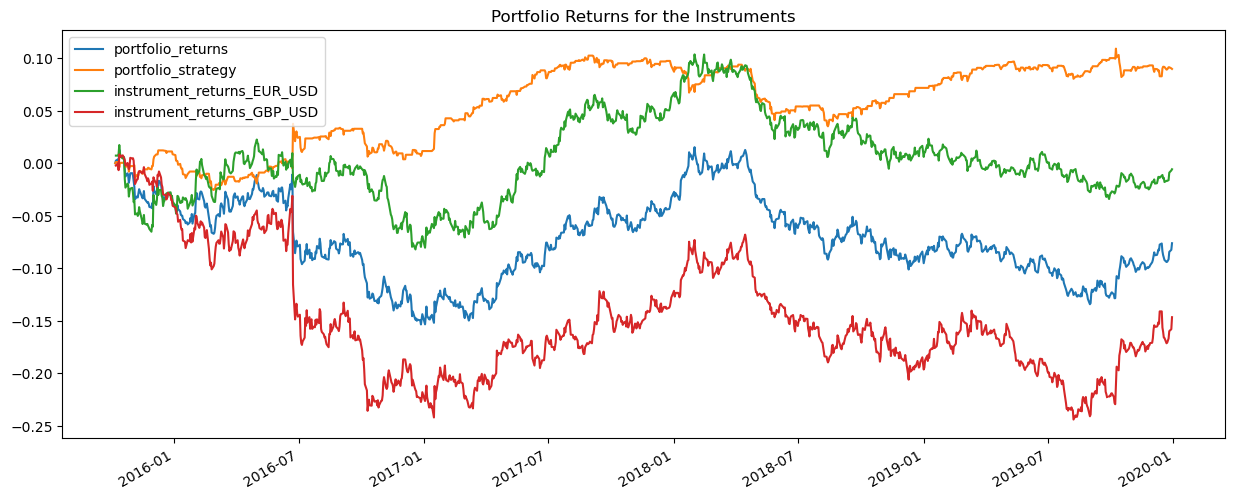

In [57]:
instruments_lis = ["EUR_USD","GBP_USD"]
params = {
    "from": "2015-01-01T00:00:00Z",  # 开始时间
    "to": "2019-12-31T23:59:59Z",  # 结束时间
    "granularity": "D"  # 日线数据
}


results = pd.DataFrame()

for instrument in instruments_lis:
    print('-------------------')
    print('Running the Strategy for:', instrument)
    print('-------------------')
    momentum_hurst_rsi = Momentum_Hurst_RSI_4(instrument, params, 5, 21, 200)
    momentum_hurst_rsi.strategy()
    results['instrument_returns_'+instrument]=momentum_hurst_rsi.visualise_data['Instrument_Returns']
    results['strategy_returns_'+ instrument] = momentum_hurst_rsi.visualise_data['Strategy_Returns']

instrument_returns = results.filter(like='instrument')
strategy_returns = results.filter(like='strategy')


results['portfolio_returns'] = instrument_returns.sum(axis=1) / len(instruments_lis)
results['portfolio_strategy'] = strategy_returns.sum(axis=1) / len(instruments_lis)

plot_title = 'Portfolio Returns for the Instruments'
columns_to_plot = ['portfolio_returns', 'portfolio_strategy'] + ['instrument_returns_' + instrument for instrument in instruments_lis]
results[columns_to_plot].cumsum().plot(title=plot_title, figsize=(15, 6))

calculate_metrics(results['portfolio_returns'], 'Portfolio Returns')
calculate_metrics(results['portfolio_strategy'], 'Portfolio Strategy')

-------------------
Running the Strategy for: EUR_USD
-------------------
-------------------
Running the Strategy for: GBP_USD
-------------------
Annual Regular Return (Portfolio Returns): -0.011879687235971548
Annual Regular Standard Deviation (Portfolio Returns): 0.080093828970179
Sharpe Ratio (Portfolio Returns): -0.14832212904185993
Annual Regular Return (Portfolio Strategy): 0.045016408424476184
Annual Regular Standard Deviation (Portfolio Strategy): 0.04285151261796085
Sharpe Ratio (Portfolio Strategy): 1.0505208725259312


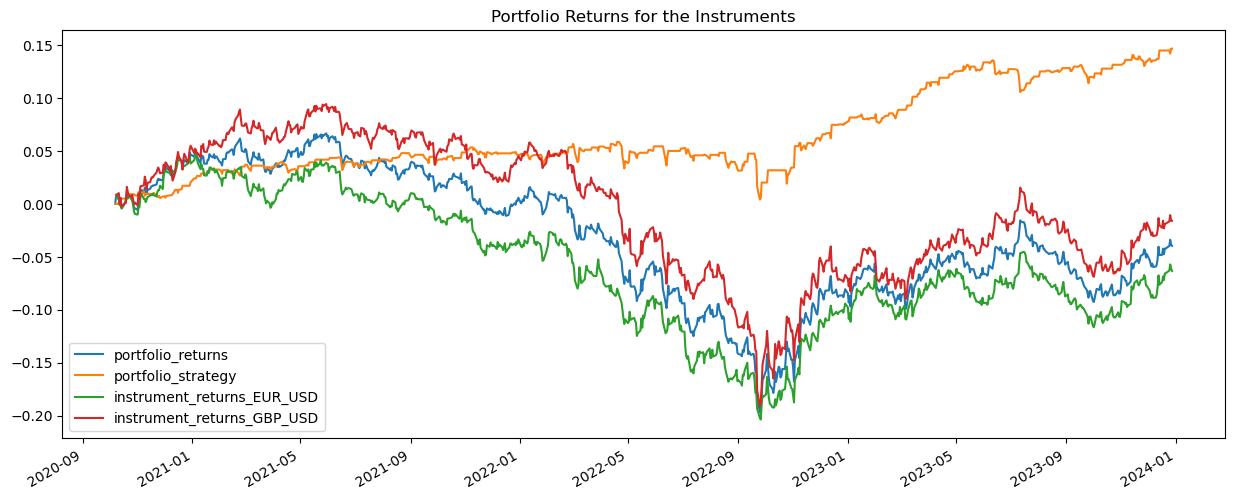

In [58]:
instruments_lis = ["EUR_USD","GBP_USD"]
bt_params = {
    "from": "2020-01-01T00:00:00Z",  # 开始时间
    "to": "2023-12-31T23:59:59Z",  # 结束时间
    "granularity": "D"  # 日线数据
}


bt_results = pd.DataFrame()

for instrument in instruments_lis:
    print('-------------------')
    print('Running the Strategy for:', instrument)
    print('-------------------')
    momentum_hurst_rsi = Momentum_Hurst_RSI_4(instrument, bt_params, 5, 21, 200)
    momentum_hurst_rsi.strategy()
    bt_results['instrument_returns_'+instrument]=momentum_hurst_rsi.visualise_data['Instrument_Returns']
    bt_results['strategy_returns_'+ instrument] = momentum_hurst_rsi.visualise_data['Strategy_Returns']

bt_instrument_returns = bt_results.filter(like='instrument')
bt_strategy_returns = bt_results.filter(like='strategy')


bt_results['portfolio_returns'] = bt_instrument_returns.sum(axis=1) / len(instruments_lis)
bt_results['portfolio_strategy'] = bt_strategy_returns.sum(axis=1) / len(instruments_lis)

plot_title = 'Portfolio Returns for the Instruments'
columns_to_plot = ['portfolio_returns', 'portfolio_strategy'] + ['instrument_returns_' + instrument for instrument in instruments_lis]
bt_results[columns_to_plot].cumsum().plot(title=plot_title, figsize=(15, 6))

calculate_metrics(bt_results['portfolio_returns'], 'Portfolio Returns')
calculate_metrics(bt_results['portfolio_strategy'], 'Portfolio Strategy')

## Step 3: Add BB into Strategy

Since BB strategy's performance is good when market volatility is large, we can conbine these two strategies together.

In [64]:
class Momentum_Hurst_RSI_5():

    def __init__(self, instrument, params, short_term_window, long_term_window, hurst_window ): # params: from, to, granularity
        self.instrument = instrument
        self.params = params
        self.ST_window = short_term_window
        self.LT_window = long_term_window
        # Hurst exponent
        self.hurst_window = hurst_window

        # RSI indicator, same as the short term window
        self.RSI_window = short_term_window
        self.window = 20
        self.window_dev = 0.8
        self.prepare_data()
    

    def prepare_data(self):
        # Make a request
        r = instruments.InstrumentsCandles(instrument=self.instrument, params=self.params)
        data = api.request(r)

        # Extract date and closing price and form as a DataFrame
        dates = [candle['time'][:10] for candle in data['candles']]  # Intercept the first 10 characters to get the date
        close_prices = [float(candle['mid']['c']) for candle in data['candles']]  # Get Close Price

        # Create DataFrame, row_index: date; column: close price
        bt_data = pd.DataFrame(data=close_prices, index=pd.to_datetime(dates), columns=['Close_Price'])


        # Calculate the momentum and the Hurst exponent
        bt_data['ShortTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.ST_window)
        bt_data['LongTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.LT_window)    
        bt_data['Hurst'] = bt_data['Close_Price'].rolling(window=self.hurst_window).apply(lambda x: compute_Hc(x)[0])

        # Calculating the RSI
        rsi_indicator = RSIIndicator(close = bt_data['Close_Price'], window = self.RSI_window, fillna = False)
        RSI = rsi_indicator.rsi()

        # Adding the RSI to the dataframe
        bt_data['RSI'] = RSI

        # Calculate the Bollinger Bands
        BB =  BollingerBands(close=bt_data['Close_Price'], window=self.window, window_dev=self.window_dev)
        bt_data['UB'] = BB.bollinger_hband() # upper band
        bt_data['MB'] = BB.bollinger_mavg()
        bt_data['LB'] = BB.bollinger_lband() # lower band

        bt_data = bt_data.dropna()
        self.data = bt_data
        
    def strategy(self):
        
        data = self.data

        # add 0 to the position column
        data['Position'] = 0
         
        # data['Position'] = 1
        data.loc[(data['Hurst'] > 0.8) & (data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] > 0), 'Position'] = 1 # Hurst exponent greater than 0.5, short term and long term momentum greater than 0, buy
        data.loc[(data['Hurst'] > 0.8) & (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] < 0), 'Position'] = -1

        # Out of the market, RSI less than 60
        data.loc[(data['Close_Price'] <= data['UB']) & (0.2 <= data['Hurst']) & (data['Hurst'] <= 0.8), 'Position'] = 1
        data.loc[(data['Close_Price'] > data['UB']) & (0.2 <= data['Hurst']) & (data['Hurst'] <= 0.8), 'Position'] = -1

        # Hurst less than 0.5, opposite of the above
        data.loc[(data['Hurst'] < 0.2) & (data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] > 0), 'Position'] = -1 # Hurst exponent greater than 0.5, short term and long term momentum greater than 0, buy
        data.loc[(data['Hurst'] < 0.2) & (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] < 0), 'Position'] = 1

        

        data['Signal'] = data['Position'].diff()
        data = data.dropna()

        data['Instrument_Returns'] = np.log(data['Close_Price']/data['Close_Price'].shift(1))
        data['Strategy_Returns'] = data['Instrument_Returns'] * data['Position'].shift(1)

        self.visualise_data = data

-------------------
Running the Strategy for: EUR_USD
-------------------
-------------------
Running the Strategy for: GBP_USD
-------------------
Annual Regular Return (Portfolio Returns): -0.017323491896074517
Annual Regular Standard Deviation (Portfolio Returns): 0.07551841849026418
Sharpe Ratio (Portfolio Returns): -0.22939426225282852
Annual Regular Return (Portfolio Strategy): 0.05898922623372749
Annual Regular Standard Deviation (Portfolio Strategy): 0.06842532085138314
Sharpe Ratio (Portfolio Strategy): 0.8620964505500757


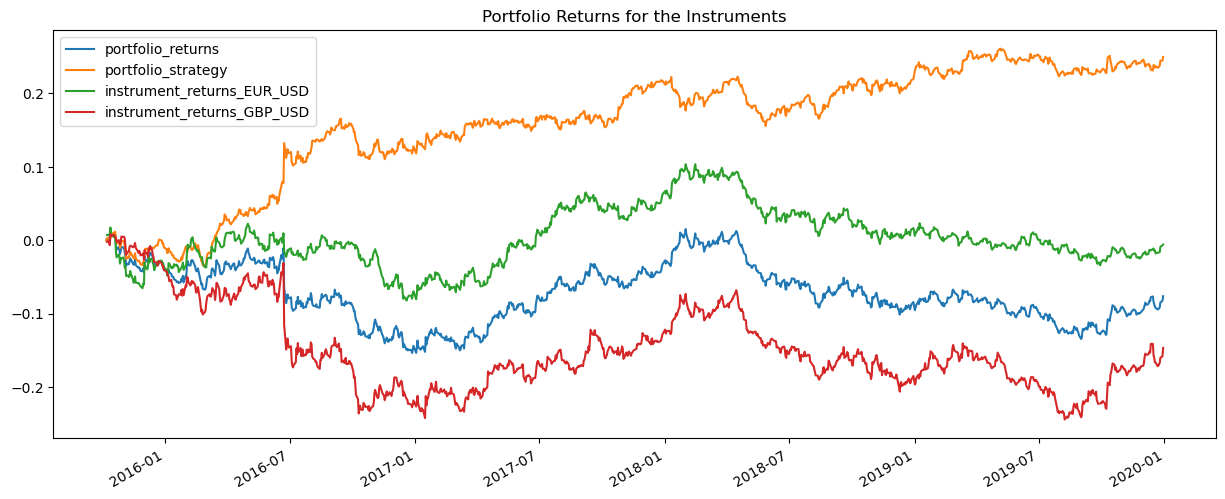

In [65]:
instruments_lis = ["EUR_USD","GBP_USD"]
params = {
    "from": "2015-01-01T00:00:00Z",  # 开始时间
    "to": "2019-12-31T23:59:59Z",  # 结束时间
    "granularity": "D"  # 日线数据
}


results = pd.DataFrame()

for instrument in instruments_lis:
    print('-------------------')
    print('Running the Strategy for:', instrument)
    print('-------------------')
    momentum_hurst_rsi = Momentum_Hurst_RSI_5(instrument, params, 5, 21, 200)
    momentum_hurst_rsi.strategy()
    results['instrument_returns_'+instrument]=momentum_hurst_rsi.visualise_data['Instrument_Returns']
    results['strategy_returns_'+ instrument] = momentum_hurst_rsi.visualise_data['Strategy_Returns']

instrument_returns = results.filter(like='instrument')
strategy_returns = results.filter(like='strategy')


results['portfolio_returns'] = instrument_returns.sum(axis=1) / len(instruments_lis)
results['portfolio_strategy'] = strategy_returns.sum(axis=1) / len(instruments_lis)

plot_title = 'Portfolio Returns for the Instruments'
columns_to_plot = ['portfolio_returns', 'portfolio_strategy'] + ['instrument_returns_' + instrument for instrument in instruments_lis]
results[columns_to_plot].cumsum().plot(title=plot_title, figsize=(15, 6))

calculate_metrics(results['portfolio_returns'], 'Portfolio Returns')
calculate_metrics(results['portfolio_strategy'], 'Portfolio Strategy')

-------------------
Running the Strategy for: EUR_USD
-------------------
-------------------
Running the Strategy for: GBP_USD
-------------------
Annual Regular Return (Portfolio Returns): -0.011879687235971548
Annual Regular Standard Deviation (Portfolio Returns): 0.080093828970179
Sharpe Ratio (Portfolio Returns): -0.14832212904185993
Annual Regular Return (Portfolio Strategy): 0.045016408424476184
Annual Regular Standard Deviation (Portfolio Strategy): 0.04285151261796085
Sharpe Ratio (Portfolio Strategy): 1.0505208725259312


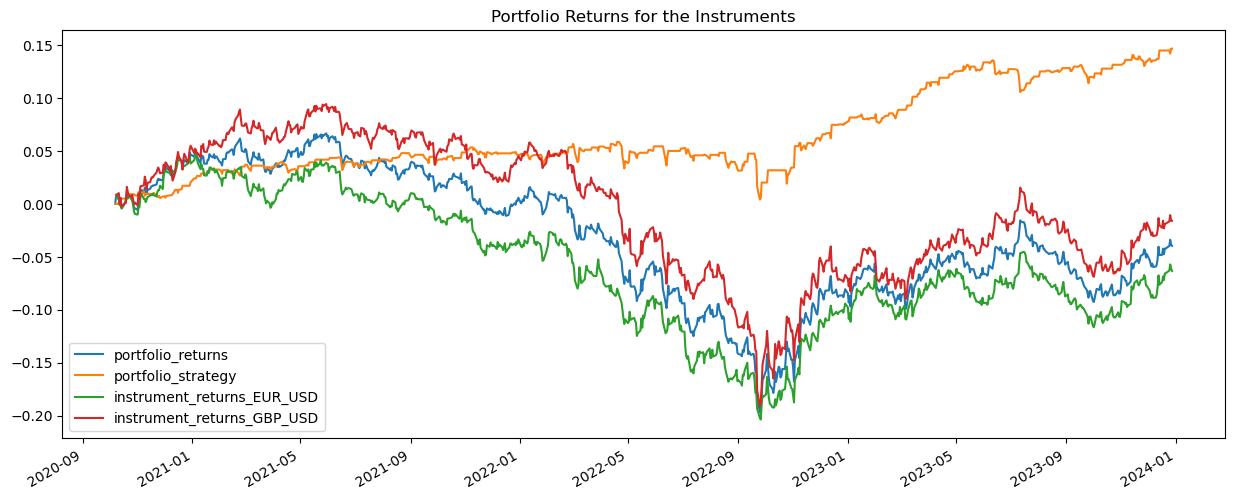

In [66]:
instruments_lis = ["EUR_USD","GBP_USD"]
bt_params = {
    "from": "2020-01-01T00:00:00Z",  # 开始时间
    "to": "2023-12-31T23:59:59Z",  # 结束时间
    "granularity": "D"  # 日线数据
}


bt_results = pd.DataFrame()

for instrument in instruments_lis:
    print('-------------------')
    print('Running the Strategy for:', instrument)
    print('-------------------')
    momentum_hurst_rsi = Momentum_Hurst_RSI_4(instrument, bt_params, 5, 21, 200)
    momentum_hurst_rsi.strategy()
    bt_results['instrument_returns_'+instrument]=momentum_hurst_rsi.visualise_data['Instrument_Returns']
    bt_results['strategy_returns_'+ instrument] = momentum_hurst_rsi.visualise_data['Strategy_Returns']

bt_instrument_returns = bt_results.filter(like='instrument')
bt_strategy_returns = bt_results.filter(like='strategy')


bt_results['portfolio_returns'] = bt_instrument_returns.sum(axis=1) / len(instruments_lis)
bt_results['portfolio_strategy'] = bt_strategy_returns.sum(axis=1) / len(instruments_lis)

plot_title = 'Portfolio Returns for the Instruments'
columns_to_plot = ['portfolio_returns', 'portfolio_strategy'] + ['instrument_returns_' + instrument for instrument in instruments_lis]
bt_results[columns_to_plot].cumsum().plot(title=plot_title, figsize=(15, 6))

calculate_metrics(bt_results['portfolio_returns'], 'Portfolio Returns')
calculate_metrics(bt_results['portfolio_strategy'], 'Portfolio Strategy')